In [1]:
import cbio_data_ingest
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from collections import OrderedDict
from scipy.stats import iqr

from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score,
    roc_curve, 
    roc_auc_score, 
    RocCurveDisplay,
    accuracy_score
)

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV

from sklearn.naive_bayes import MultinomialNB

#https://personal.sron.nl/~pault/#sec:qualitative

In [2]:
def check_missing_data(df):
    '''Quick view of missing data in df, returns df populated with percentage of missing values'''
    missing_data = (pd.DataFrame(data=df.isna().mean() * 100,
               columns=['Percent_Missing']) \
               .sort_values(by='Percent_Missing', ascending=False)
               )
    return missing_data

In [ ]:
def pipe_run(X_train, X_test, y_train, y_test, pipe,param_grid):
   
    grid = GridSearchCV(pipe, param_grid, cv=5,verbose=1)
    grid.fit(X_train, y_train)

    print("Best params:\n{}\n".format(grid.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
    
    best_params = pd.DataFrame(grid.cv_results_) \
             .sort_values('mean_test_score', ascending=False) \
             .drop_duplicates(['param_classifier']) 
    
    return best_params

In [ ]:
def pipe_extract(best_params,X_test,y_test):
    
    rez = {}

    for idx, algo in best_params.iterrows():
        base_label = str(algo.params['classifier']).split('(')[0]

        pipe = Pipeline([(base_label, algo['params']['classifier'])])
        print(f"...Working on {pipe}...")
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        print('...Fit and predicted...')
        fpr, tpr, _ = roc_curve(preds, y_test)
        auc = roc_auc_score(y_test, preds)
        annot = f"{base_label} (AUC={round(auc,2)})"
        print(annot)
        print('************')
        rez[base_label] = [fpr,tpr,annot]
    
    return rez

In [ ]:
def pipe_rez_plot(optimized_fpr_dict,title):
    colors = {'SVC': 'blue', 'MLPClassifier': 'orange', 'RandomForestClassifier': 'green', 'LogisticRegression': 'purple'}

    for k,v in optimized_fpr_dict.items():
        plt.plot(v[0],v[1],color=colors[k],label=v[2],linewidth=2)

    plt.legend(loc='lower right')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)
    plt.show()

In [3]:
raw_data_loc = '/Users/erin/Downloads/220215_msk_met_2021'
raw_data_dict = cbio_data_ingest.grab_cbio_data(raw_data_loc)

cbio_data_ingest.report_cbio_data_ingest(raw_data_dict)

DATA INGEST REPORT
********************
DATA CATEGORY: meta
   VALUES: 11
     sample (3, 1)
     sv (7, 1)
     diagnosis (3, 1)
     status (3, 1)
     sequencing (3, 1)
     seg (5, 1)
     matrix (3, 1)
     study (6, 1)
     mutations (7, 1)
     surgery (3, 1)
     patient (3, 1)
********************
DATA CATEGORY: data
   VALUES: 10
     patient (25775, 10)
     surgery (24953, 4)
     hg19 (1450474, 6)
     status (25669, 5)
     sample (25775, 42)
     sv (6880, 26)
     matrix (25775, 4)
     mutations (230419, 122)
     diagnosis (125873, 6)
     sequencing (25517, 5)
********************
DATA CATEGORY: cases
   VALUES: 5
     sv (6, 1)
     cna (6, 1)
     sequenced (6, 1)
     cnaseq (6, 1)
     all (6, 1)


In [4]:
processed_data_dict = {}

processed_data_dict['meta'] = cbio_data_ingest.reorg_cbio_meta_data(raw_data_dict['meta'])
processed_data_dict['cases'] = cbio_data_ingest.reorg_cbio_meta_data(raw_data_dict['cases'])
#placeholder dictionary for now -- inner dict will be populated as a result of cleaning/munging raw_data_dict dicts
processed_data_dict['data'] = {}

for k, v in processed_data_dict['cases'].items():
    #cleaning metadata only
    #will reference raw_data_dict for the actual scientific data, 
    #which has not been modified at this point
        v.loc['case_list_ids']['Value'] = v.loc['case_list_ids']['Value'].lstrip().replace('\t',', ')

In [5]:
#Checking for missing data in SAMPLE

missing_data_pat = check_missing_data(raw_data_dict['data']['sample'])
missing_data_pat.head(10)

Percent_Missing
METASTATIC_SITE                 60.647915
TUMOR_PURITY                     1.579049
MSI_SCORE                        0.007759
MSI_TYPE                         0.003880
PRIMARY_SITE                     0.003880
SAMPLE_ID                        0.000000
DMETS_DX_ADRENAL_GLAND           0.000000
DMETS_DX_BILIARY_TRACT           0.000000
DMETS_DX_INTRA_ABDOMINAL         0.000000
DMETS_DX_BOWEL                   0.000000

In [6]:
#METASTATIC_SITE is missing only in cases where SAMPLE_TYPE == Primary (e.g., no metastasis)
raw_data_dict['data']['sample'] \
.loc[raw_data_dict['data']['sample']['METASTATIC_SITE'] \
.isna()]['SAMPLE_TYPE'] \
.value_counts()

Primary    15632
Name: SAMPLE_TYPE, dtype: int64

In [7]:
#not immediately clear why TUMOR_PURITY is missing in 407 cases -- will impute with mean of ONCOTREE_CODE for now
raw_data_dict['data']['sample'] \
.loc[raw_data_dict['data']['sample']['TUMOR_PURITY'].isna()].head()

SAMPLE_ID PATIENT_ID            ORGAN_SYSTEM ONCOTREE_CODE  \
5   P-0000027-T01-IM3  P-0000027                Thoracic       PLEMESO   
29  P-0000082-T01-IM3  P-0000082                Thoracic          LUAD   
45  P-0000112-T01-IM3  P-0000112                 Core GI          ESCA   
55  P-0000127-T02-IM3  P-0000127  Developmental GI Tract          IHCH   
57  P-0000130-T01-IM3  P-0000130                Thoracic          SCLC   

                     SUBTYPE SUBTYPE_ABBREVIATION SAMPLE_TYPE PRIMARY_SITE  \
5       Pleural Mesothelioma               PLMESO     Primary         Lung   
29       Lung Adenocarcinoma                 LUAD     Primary         Lung   
45  Esophageal Adenocarinoma                 ESCA     Primary    Esophagus   
55    Cholangio Intrahepatic           CHOL intra  Metastasis        Liver   
57    Small Cell Lung Cancer                 SCLC     Primary         Lung   

   METASTATIC_SITE GENE_PANEL  ...  DMETS_DX_ADRENAL_GLAND  DMETS_DX_KIDNEY  \
5              NaN  IMPACT341  ...                      No               No   
29             NaN  IMPACT341  ...                      No               No   
45             NaN  IMPACT341  ...                      No               No   
55           Lymph  IMPACT341  ...                      No               No   
57             NaN  IMPACT341  ...                      No               No   

    DMETS_DX_BLADDER_UT  DMETS_DX_FEMALE_GENITAL  DMETS_DX_OVARY  \
5                    No                       No              No   
29                   No                       No              No   
45                   No                       No              No   
55                   No                       No              No   
57                   No                       No              No   

   DMETS_DX_MALE_GENITAL DMETS_DX_SKIN  DMETS_DX_HEAD_NECK  DMETS_DX_BREAST  \
5                     No            No                  No               No   
29                    No            No                  No               No   
45                    No            No                  No               No   
55                    No            No                  No               No   
57                    No            No                  No               No   

   TMB_NONSYNONYMOUS  
5           0.000000  
29         13.309864  
45          8.873242  
55          2.218311  
57          4.436621  

[5 rows x 42 columns]

In [8]:
#Checking for missing data in PATIENT
missing_data_pat = check_missing_data(raw_data_dict['data']['patient'])
missing_data_pat.head(10)

Percent_Missing
AGE_AT_DEATH                   61.113482
AGE_AT_LAST_CONTACT            39.297769
AGE_AT_EVIDENCE_OF_METS        23.809893
AGE_AT_SURGERY                  3.189137
AGE_AT_SEQUENCING               1.000970
OS_MONTHS                       0.450048
RACE                            0.298739
SEX                             0.015519
PATIENT_ID                      0.000000
OS_STATUS                       0.000000

In [9]:
#are there samples where ALL quant columns are NaN? 
#yes, we go from 25,775 rows to 25,674 rows, we lose ~100 samples, but 
#it's hard to justify keeping those samples 
print(f"Original data: {raw_data_dict['data']['patient'].shape} \n\
Would-be data: {raw_data_dict['data']['patient'].dropna(how='all',subset=raw_data_dict['data']['patient'].select_dtypes(include=[float,int]).columns,axis=0).shape}")

Original data: (25775, 10) 
Would-be data: (25674, 10)


In [10]:
#build processed_data_dict, only modifying 'patient' and 'sample' and pivoting 'mutations' for now 
#the majority of people in this dataset who are deceased do not have an AGE_AT_LAST_CONTACT
#I will instead take the highest age in that row and substitute that age for AGE_AT_LAST_CONTACT

for k,v in raw_data_dict['data'].items():
    if k == 'patient':
        #select rows where AGE_AT_LAST_CONTACT is missing, and then take the max of the other 4 related columns
        #to be the imputed value
        max_age_impute = (v.loc[v['AGE_AT_LAST_CONTACT'].isna()] \
                          [['AGE_AT_EVIDENCE_OF_METS','AGE_AT_SEQUENCING','AGE_AT_DEATH','AGE_AT_SURGERY']] 
                          .max(axis=1))
        
        #dictionary of values to fillnas with -- different columns have different values
        #in the cases where AGE_AT_DEATH, AGE_AT_SURGERY, and AGE_AT_EVIDENCE_OF_METS are missing,
        #I've shown that this is because the patient did not die, or did not have mets, or did not 
        #require surgery, so I replace those values with an artificially high age 
        values = {'AGE_AT_DEATH': 150, 
                  'AGE_AT_EVIDENCE_OF_METS': 150, 
                  'AGE_AT_LAST_CONTACT': max_age_impute, 
                  'AGE_AT_SURGERY': 150}

        processed_data_dict['data'][k] = (v \
                                        .replace({'0:LIVING': 0, '1:DECEASED': 1}) \
                                        .fillna(value=values)
                                        #.dropna(how='any',axis=0) #initial EDA showed that, for values that
                                          #could not be imputed, <1% of data were missing, so it is more
                                          #conservative IMO to drop these rows entirely
                                         )
    elif k == 'sample':
        #I am encoding PRIMARY_SITE and ORGAN_SYSTEM with numbers here, as I will try
        #to use these two columns as features later on for ML 
        pri_site = pd.get_dummies(v['PRIMARY_SITE'],prefix='primary_site')
        org_syst = pd.get_dummies(v['ORGAN_SYSTEM'],prefix='organ')
        
        intermediate_v = pd.concat([v,org_syst,pri_site],axis=1).drop(columns=['ORGAN_SYSTEM','PRIMARY_SITE'])
        
        #in cases where TUMOR_PURITY or MSI_SCORE are missing, I impute with the mean values
        #of the oncotree code/cancer subtype
        
        values = {'METASTATIC_SITE': 'Non-metastatic', 
                  'TUMOR_PURITY': v['TUMOR_PURITY'].fillna(v.groupby('ONCOTREE_CODE')['TUMOR_PURITY'].transform('mean')),
                  'MSI_SCORE': v['MSI_SCORE'].fillna(v.groupby('ONCOTREE_CODE')['MSI_SCORE'].transform('mean')),
                 }
        processed_data_dict['data'][k] = (intermediate_v \
                                        .replace({'No': 0, 'Yes': 1})
                                        .fillna(value=values)
                                         )
    elif k == 'mutations':
        #here I pivot the mutation table -- rows are patients, columns are the Hugo Symbol
        #of all genes, and then I take the length of the Variant Classification.
        #so if there are 4 mutations in a gene, the value is 4 here. 
        #if there are 3 frameshift and 1 stop mutation, we don't capture that difference here,
        #the value is still reported as 4.
        processed_data_dict['data']['mutations'] = (v \
                                                    .pivot_table(index='Tumor_Sample_Barcode',
                                                                 columns='Hugo_Symbol',
                                                                 values='Variant_Classification',
                                                                 aggfunc=len) \
                                                   .fillna(0)
                                                   .astype(int))
    else:
        #if no munging is required, just copy the data from the raw data
        processed_data_dict['data'][k] = v.copy(deep=True)

In [11]:
#here is what the mutations matrix looks like -- Genes (Hugo Symbols) as features, patients as rows 
processed_data_dict['data']['mutations'].head()

#TESTING CODE 
#------------------
#muts.loc[muts.index == 'P-0040823-T01-IM6']['AGO2']
#Tumor_Sample_Barcode
#P-0040823-T01-IM6    3.0
#Name: AGO2, dtype: float64

#processed_data_dict['data']['mutations'].loc[(processed_data_dict['data']['mutations']['Tumor_Sample_Barcode'] == 'P-0040823-T01-IM6') &
#                                             (processed_data_dict['data']['mutations']['Hugo_Symbol'] == 'AGO2')]
#10998	AGO2	27161	MSKCC	GRCh37	8	141554345	141554345	+	frameshift_variant	Frame_Shift_Del	...
#11003	AGO2	27161	MSKCC	GRCh37	8	141561430	141561430	+	frameshift_variant	Frame_Shift_Del	...
#11051	AGO2	27161	MSKCC	GRCh37	8	141569599	141569599	+	missense_variant	Missense_Mutatio

#print(processed_data_dict['data']['sample'].shape, muts.shape)
#(25773, 42) (24755, 493)

#processed_data_dict['data']['sample'][~processed_data_dict['data']['sample']['SAMPLE_ID'].isin(muts.index)]
#lose 1020 rows ... I manually spot-checked some of them in the cBioportal API and they truly have no mutations
#(some have SVs like P-0050249-T01-IM6 (https://www.cbioportal.org/patient?sampleId=P-0050249-T01-IM6&studyId=msk_met_2021) which are outside the scope of this feature matrix for the moment)
#but some like P-0050210-T01-IM6 have no listed mutations, SVs, or CNAs (https://www.cbioportal.org/patient?sampleId=P-0050210-T01-IM6&studyId=msk_met_2021)

Hugo_Symbol           ABL1  AC004906.3  AC008738.1  ACVR1  AGO2  AKT1  AKT2  \
Tumor_Sample_Barcode                                                          
P-0000004-T01-IM3        0           0           0      0     0     1     0   
P-0000015-T01-IM3        0           0           0      0     0     0     0   
P-0000024-T01-IM3        0           0           0      0     0     0     0   
P-0000025-T02-IM5        0           0           0      0     0     0     0   
P-0000026-T01-IM3        0           0           0      0     0     0     0   

Hugo_Symbol           AKT3  ALK  ALOX12B  ...  WHSC1L1  WT1  WWTR1  XIAP  \
Tumor_Sample_Barcode                      ...                              
P-0000004-T01-IM3        0    0        0  ...        0    0      0     0   
P-0000015-T01-IM3        0    1        0  ...        0    0      0     0   
P-0000024-T01-IM3        0    0        0  ...        0    0      0     0   
P-0000025-T02-IM5        0    0        0  ...        0    0      0     0   
P-0000026-T01-IM3        0    0        0  ...        0    0      0     0   

Hugo_Symbol           XPO1  XRCC2  YAP1  YES1  ZFHX3  ZRSR2  
Tumor_Sample_Barcode                                         
P-0000004-T01-IM3        0      0     0     0      0      0  
P-0000015-T01-IM3        0      0     0     0      0      0  
P-0000024-T01-IM3        0      0     0     0      0      0  
P-0000025-T02-IM5        0      0     0     0      0      0  
P-0000026-T01-IM3        0      0     0     0      0      0  

[5 rows x 493 columns]

In [12]:
#here I combine attributes of the patient and the sample
#I end up dropping TUMOR_PURITY because I did not think it relevant for any
#ML algos I wanted to try. 
#TODO: clean this step up

processed_data_dict['samp_pat'] = pd.merge(processed_data_dict['data']['sample'],
                                           processed_data_dict['data']['patient'],
                                           left_on='PATIENT_ID',
                                           right_on='PATIENT_ID',
                                           how='outer') \
                                          .drop(columns=['AGE_AT_LAST_CONTACT','SAMPLE_COVERAGE','MET_SITE_COUNT','TUMOR_PURITY'])

In [13]:
#here I create the df for ML -- I want all attributes of the sample, the patient,
#and the mutations matrix

for_ml = pd.merge(processed_data_dict['samp_pat'],
             processed_data_dict['data']['mutations'],
             left_on='SAMPLE_ID',
             right_on=processed_data_dict['data']['mutations'].index)\
             .dropna(how='any',axis=0)

In [14]:
#here is the final DF for ML 
#TODO: how to clean this up and make this more programmatic? 
for_ml.head()

SAMPLE_ID PATIENT_ID ONCOTREE_CODE                 SUBTYPE  \
0  P-0000004-T01-IM3  P-0000004           IDC  Breast Ductal HR+HER2-   
1  P-0000015-T01-IM3  P-0000015           IDC  Breast Ductal HR+HER2-   
2  P-0000024-T01-IM3  P-0000024           UEC    Uterine Endometrioid   
3  P-0000025-T02-IM5  P-0000025           USC          Uterine Serous   
4  P-0000026-T01-IM3  P-0000026           UEC    Uterine Endometrioid   

  SUBTYPE_ABBREVIATION SAMPLE_TYPE  METASTATIC_SITE GENE_PANEL  \
0         IDC HR+HER2-     Primary   Non-metastatic  IMPACT341   
1         IDC HR+HER2-  Metastasis            Liver  IMPACT341   
2            UCEC ENDO  Metastasis             Lung  IMPACT341   
3          UCEC SEROUS  Metastasis  Intra-Abdominal  IMPACT410   
4            UCEC ENDO  Metastasis      Unspecified  IMPACT341   

   IS_DIST_MET_MAPPED  MET_COUNT  ... WHSC1L1 WT1  WWTR1  XIAP XPO1  XRCC2  \
0                True          2  ...       0   0      0     0    0      0   
1                True          8  ...       0   0      0     0    0      0   
2                True          8  ...       0   0      0     0    0      0   
3                True         13  ...       0   0      0     0    0      0   
4                True         11  ...       0   0      0     0    0      0   

   YAP1  YES1  ZFHX3  ZRSR2  
0     0     0      0      0  
1     0     0      0      0  
2     0     0      0      0  
3     0     0      0      0  
4     0     0      0      0  

[5 rows x 738 columns]

## EDA: Scaling and Dimensionality Reduction

I now have 524 features and 24,445 samples. This is largely a sparse matrix. Many of the features are zero -- are there any features I can get rid of and not lose any information? Pruning my features will help streamline the testing and optimization of machine learning algorithms.

#### Test 1: PCA 

__Goal:__ Use PCA to distill 524 features into a more manageable number of principal components<br>
__Results:__ I can distill features into 5 principal components and explain 97% of the variance in the data<br>
__Next Steps:__ Test classfiers with untransformed features and PCs, compare performance<br>

In [15]:
X = for_ml.select_dtypes(include=[float,int]) #524 features is too many for my laptop! 
y = for_ml['SAMPLE_TYPE'].replace({'Primary': 0, 'Metastasis': 1}) #target: is the sample a Primary tumor or Metastasis?

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pca = PCA(n_components=5,whiten=True)
# fit PCA model 
pca.fit(X_train)
# transform data onto the first two principal components
X_pca = pca.transform(X_train)

print("Original shape: {}".format(str(X_train.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
print(f"PCs explain {round(pca.explained_variance_ratio_.sum() * 100,2)}% variability in data")

Original shape: (16378, 524)
Reduced shape: (16378, 5)
PCs explain 97.63% variability in data


In [16]:
exp_var = pd.DataFrame(data=pca.explained_variance_ratio_ * 100,index=pca.get_feature_names_out())

px.bar(data_frame=exp_var,
       barmode='group',

       color_discrete_sequence=['gray']).update_layout(
                        template='simple_white',
                        font_family='Arial',
                        title={
                                'text': f"PCs explain {round(pca.explained_variance_ratio_.sum() * 100,2)}% variability in data",
                              },
                        xaxis_title='Principal Component', 
                        yaxis_title='Variance Explained (%)',
                        showlegend=False
                    ) 

In [17]:
pcs = pd.DataFrame(data=X_pca,columns=pca.get_feature_names_out(),index=y_train)
pcs.head()

pca0      pca1      pca2      pca3      pca4
SAMPLE_TYPE                                                  
0           -0.472380 -0.692656  1.057143 -0.767182 -0.260805
0           -0.279864 -1.301251 -0.224931 -0.245617  0.972517
0           -0.563951  2.041196  0.633253 -0.314695  2.609056
0           -1.439711  1.037210  0.277089 -0.700591 -0.044549
0           -0.134473  2.481772 -0.286238 -0.194897  0.129714

In [18]:
px.scatter_3d(data_frame=pcs,x='pca0',y='pca1',z='pca2',color=pcs.index)

### Classification Task: Prediction of Benign vs. Metastatic Tumors

In [19]:
#Test 1: optimize just one classification model 
X = for_ml.select_dtypes(include=[float,int]) #524 features is too many for my laptop! 
y = for_ml['SAMPLE_TYPE'].replace({'Primary': 0, 'Metastasis': 1}) #target: is the sample a Primary tumor or Metastasis?

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [20]:
lr_clf = LogisticRegressionCV(cv=5, 
                              Cs=[0.0001,0.01,0.1,1],
                              tol=1e-02,
                              max_iter=300,
                              solver='newton-cholesky',
                              penalty='l2',
                              random_state=42).fit(X_train, y_train)

print("Training set score: {:.3f}".format(lr_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_clf.score(X_test, y_test)))

preds = lr_clf.predict(X_test)
lr_fpr, lr_tpr, _ = roc_curve(preds, y_test)

Training set score: 0.700
Test set score: 0.686


In [21]:
X = pcs.reset_index().drop(columns=['SAMPLE_TYPE'])
y = pcs.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr_clf = LogisticRegressionCV(cv=5, 
                              Cs=[0.0001,0.01,0.1,1],
                              tol=1e-02,
                              max_iter=300,
                              solver='newton-cholesky',
                              penalty='l2',
                              random_state=42).fit(X_train, y_train)

print("Training set score: {:.3f}".format(lr_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_clf.score(X_test, y_test)))

pc_preds = lr_clf.predict(X_test)
pc_lr_fpr, pc_lr_tpr, _ = roc_curve(pc_preds, y_test)

Training set score: 0.646
Test set score: 0.647


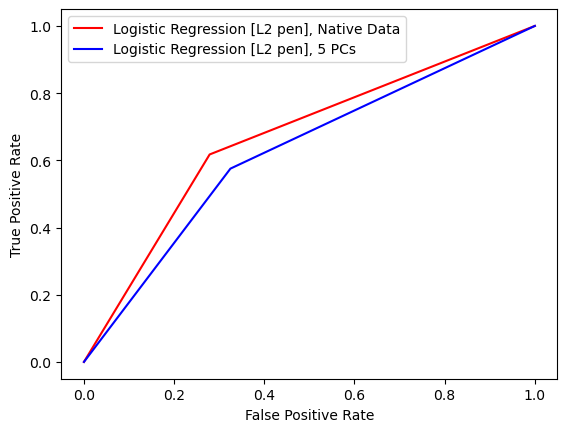

In [22]:
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression [L2 pen], Native Data',color='red')
plt.plot(pc_lr_fpr, pc_lr_tpr, label='Logistic Regression [L2 pen], 5 PCs',color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Messing with Pipe

In [110]:
pipe = Pipeline([('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=300)],
     'classifier__max_features': ['sqrt', 'log2']},
    {'classifier': [MLPClassifier(random_state=42, max_iter=3000)], 
    'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [LogisticRegression(solver='saga',penalty='l1')],'classifier__C': [0.01, 0.1, 1, 10, 100]}
    ]

In [114]:
X = pcs.reset_index().drop(columns=['SAMPLE_TYPE'])
y = pcs.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
best_params = pipe_run(X_train, X_test, y_train, y_test,pipe,param_grid)
opt_fprs = pipe_extract(best_params,X_test,y_test)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best params:
{'classifier': SVC(C=100, gamma=0.1), 'classifier__C': 100, 'classifier__gamma': 0.1}

Best cross-validation score: 0.69
Test-set score: 0.69
...Working on Pipeline(steps=[('SVC', SVC(C=100, gamma=0.1))])...
...Fit and predicted...
AUC TEST: (Int64Index([0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
            ...
            0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
           dtype='int64', name='SAMPLE_TYPE', length=5405), array([0, 0, 0, ..., 0, 1, 0]))
SVC (AUC=0.66)
************
...Working on Pipeline(steps=[('MLPClassifier',
                 MLPClassifier(max_iter=3000, random_state=42))])...
...Fit and predicted...
AUC TEST: (Int64Index([0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
            ...
            0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
           dtype='int64', name='SAMPLE_TYPE', length=5405), array([0, 0, 0, ..., 0, 1, 0]))
MLPClassifier (AUC=0.66)
************
...Working on Pipeline(steps=[('RandomForestClassifier',
                 Rand

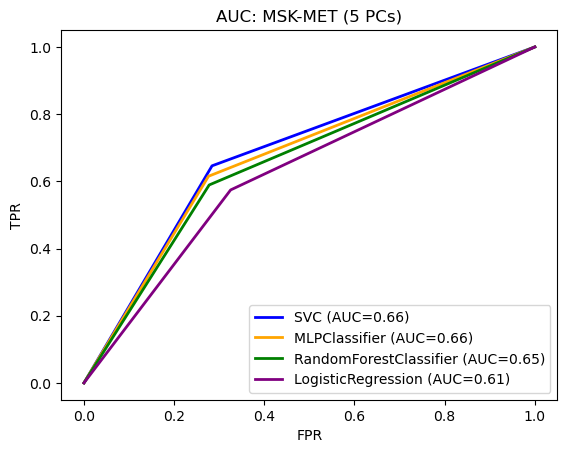

In [170]:
pipe_rez_plot(best_params_per_model,'AUC: MSK-MET (5 PCs)')

In [ ]:
#want to test out regularization as feature engineering strategy INSTEAD of using PCs

In [100]:
X = for_ml.select_dtypes(include=[float,int]) #524 features is too many for my laptop! 
y = for_ml['SAMPLE_TYPE'].replace({'Primary': 0, 'Metastasis': 1}) #target: is the sample a Primary tumor or Metastasis?

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [102]:
reg_feats = {}

Cs = [0.001,0.01,0.1,1]

for C in Cs:
    print(f"Working on selecting features using {C} as C")
    lr_l1_pen = LogisticRegression(penalty="l1", C=C,solver="liblinear")
    lr_l1_pen.fit(X, y)
    print("...Fit model...")
    model_L1_penalty = SelectFromModel(lr_l1_pen, prefit=True)
    indices_L1_penalty = model_L1_penalty.get_support()
    colnames_L1_penalty = X.columns[indices_L1_penalty]
    print(f"Selected {len(colnames_L1_penalty)} features from original {X.shape[1]} features")
    print("...Saving new features in reg_feats dict...")
    print("*********")
    reg_feats[C] = X.loc[:, indices_L1_penalty]

Working on selecting features using 0.001 as C
...Fit model...
Selected 7 features from original 524 features
...Saving new features in reg_feats dict...
*********
Working on selecting features using 0.01 as C
...Fit model...
Selected 21 features from original 524 features
...Saving new features in reg_feats dict...
*********
Working on selecting features using 0.1 as C
...Fit model...
Selected 160 features from original 524 features
...Saving new features in reg_feats dict...
*********
Working on selecting features using 1 as C
...Fit model...
Selected 441 features from original 524 features
...Saving new features in reg_feats dict...
*********


Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best params:
{'classifier': SVC(C=100, gamma=0.001), 'classifier__C': 100, 'classifier__gamma': 0.001}

Best cross-validation score: 0.70
Test-set score: 0.71
...Working on Pipeline(steps=[('SVC', SVC(C=100, gamma=0.001))])...
...Fit and predicted...
SVC (AUC=0.68)
************
...Working on Pipeline(steps=[('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=300))])...
...Fit and predicted...
RandomForestClassifier (AUC=0.66)
************
...Working on Pipeline(steps=[('MLPClassifier',
                 MLPClassifier(max_iter=3000, random_state=42))])...
...Fit and predicted...
MLPClassifier (AUC=0.69)
************
...Working on Pipeline(steps=[('LogisticRegression',
                 LogisticRegression(penalty='l1', solver='saga'))])...
...Fit and predicted...
LogisticRegression (AUC=0.62)
************


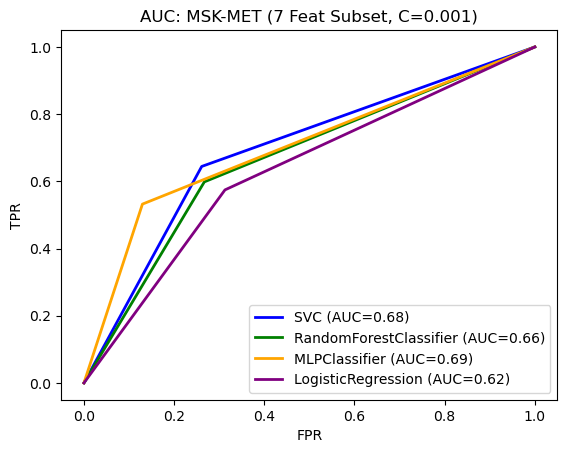

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-p

Best params:
{'classifier': SVC(C=100, gamma=0.001), 'classifier__C': 100, 'classifier__gamma': 0.001}

Best cross-validation score: 0.72
Test-set score: 0.73
...Working on Pipeline(steps=[('SVC', SVC(C=100, gamma=0.001))])...
...Fit and predicted...
SVC (AUC=0.71)
************
...Working on Pipeline(steps=[('MLPClassifier',
                 MLPClassifier(max_iter=3000, random_state=42))])...
...Fit and predicted...
MLPClassifier (AUC=0.7)
************
...Working on Pipeline(steps=[('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=300))])...
...Fit and predicted...
RandomForestClassifier (AUC=0.68)
************
...Working on Pipeline(steps=[('LogisticRegression',
                 LogisticRegression(penalty='l1', solver='saga'))])...


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



...Fit and predicted...
LogisticRegression (AUC=0.62)
************


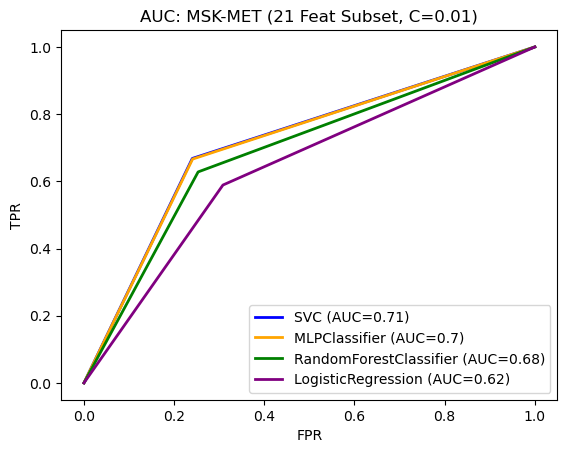

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-p

Best params:
{'classifier': SVC(C=10, gamma=0.001), 'classifier__C': 10, 'classifier__gamma': 0.001}

Best cross-validation score: 0.72
Test-set score: 0.72
...Working on Pipeline(steps=[('SVC', SVC(C=10, gamma=0.001))])...
...Fit and predicted...
SVC (AUC=0.7)
************
...Working on Pipeline(steps=[('MLPClassifier',
                 MLPClassifier(max_iter=3000, random_state=42))])...
...Fit and predicted...
MLPClassifier (AUC=0.67)
************
...Working on Pipeline(steps=[('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=300))])...
...Fit and predicted...
RandomForestClassifier (AUC=0.69)
************
...Working on Pipeline(steps=[('LogisticRegression',
                 LogisticRegression(penalty='l1', solver='saga'))])...
...Fit and predicted...
LogisticRegression (AUC=0.63)
************


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



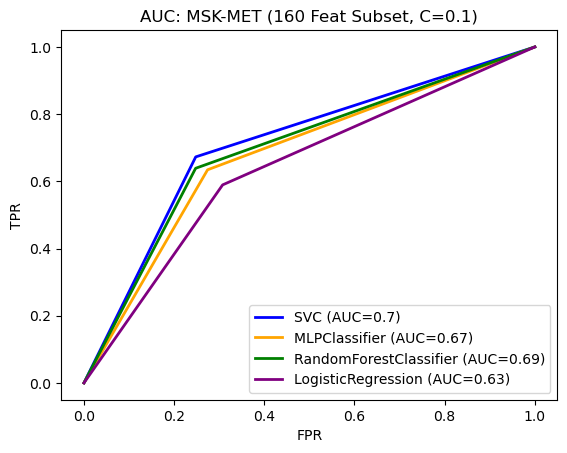

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-p

Best params:
{'classifier': SVC(C=10, gamma=0.001), 'classifier__C': 10, 'classifier__gamma': 0.001}

Best cross-validation score: 0.72
Test-set score: 0.72
...Working on Pipeline(steps=[('SVC', SVC(C=10, gamma=0.001))])...
...Fit and predicted...
SVC (AUC=0.7)
************
...Working on Pipeline(steps=[('MLPClassifier',
                 MLPClassifier(max_iter=3000, random_state=42))])...
...Fit and predicted...
MLPClassifier (AUC=0.64)
************
...Working on Pipeline(steps=[('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=300))])...
...Fit and predicted...
RandomForestClassifier (AUC=0.69)
************
...Working on Pipeline(steps=[('LogisticRegression',
                 LogisticRegression(penalty='l1', solver='saga'))])...


/Users/erin/opt/miniconda3/envs/DS_pub/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



...Fit and predicted...
LogisticRegression (AUC=0.63)
************


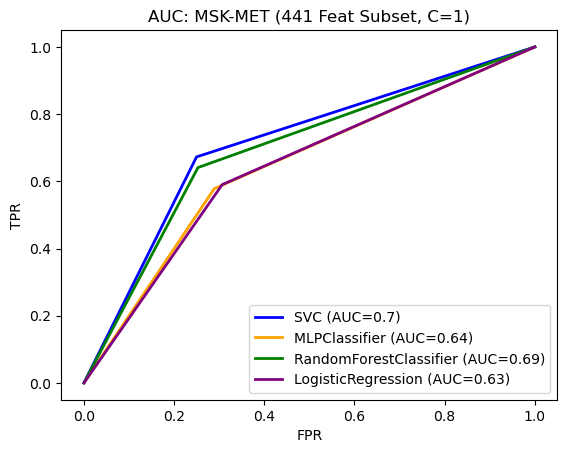

In [191]:
pipe = Pipeline([('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=300)],
     'classifier__max_features': ['sqrt', 'log2']},
    {'classifier': [MLPClassifier(random_state=42, max_iter=3000)], 
    'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [LogisticRegression(solver='saga',penalty='l1')],'classifier__C': [0.01, 0.1, 1, 10, 100]}
    ]

y = for_ml['SAMPLE_TYPE'].replace({'Primary': 0, 'Metastasis': 1})

for C_val, X in reg_feats.items():
    #k is C value, v is X
    addl_annot = f"({X.shape[1]} Feat Subset, C={C_val})"

    new_title = 'AUC: MSK-MET ' + addl_annot
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    best_reg_params = pipe_run(X_train, X_test, y_train, y_test,pipe,param_grid)
    opt_reg_fprs = pipe_extract(best_reg_params,X_test,y_test)
    pipe_rez_plot(opt_reg_fprs,new_title)

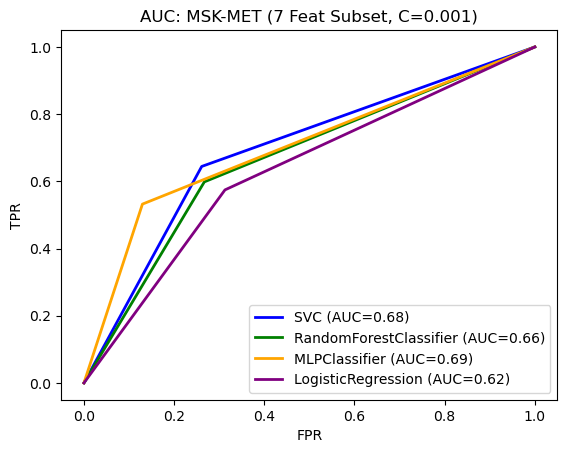

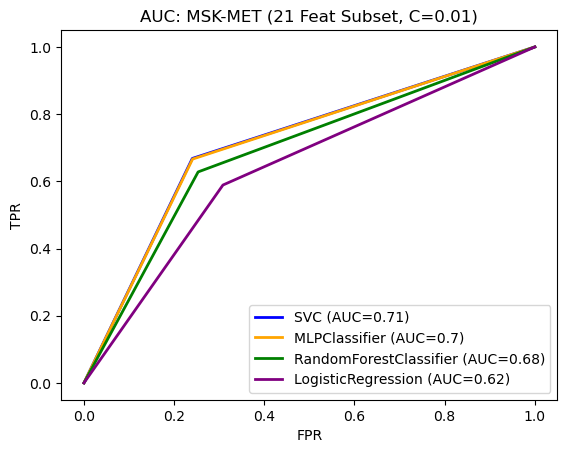

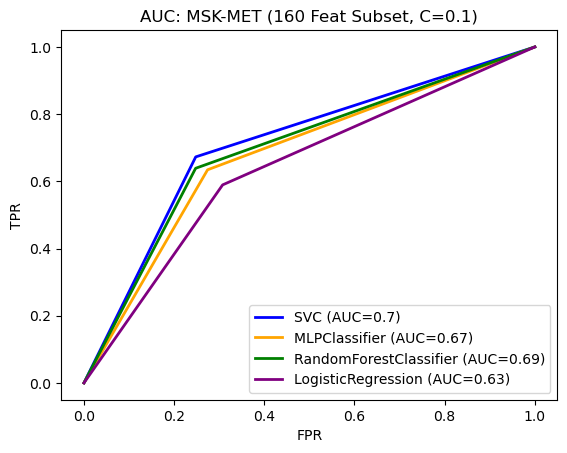

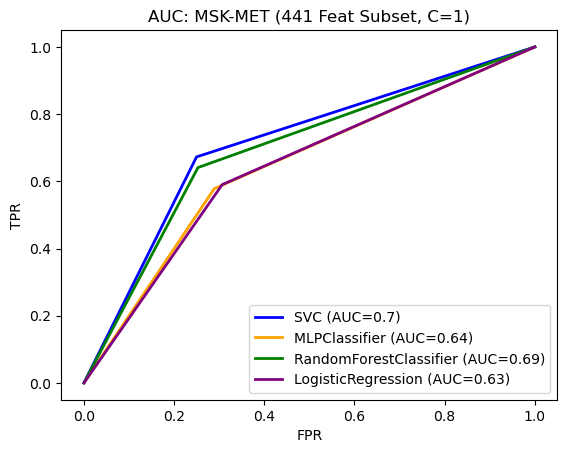